In [27]:
# 📘 תא “הוכחת ריצה” + קונפיגורציה בסיסית (תמיד ידפיס חותמת-זמן)
import sys, platform, datetime
print("=== NLP Text Processing Pipeline (20k subset) ===")
print("Python:", sys.version.split()[0], "| Platform:", platform.platform())
print("Run started at:", datetime.datetime.now().isoformat(timespec='seconds'))


=== NLP Text Processing Pipeline (20k subset) ===
Python: 3.12.12 | Platform: Linux-6.6.105+-x86_64-with-glibc2.35
Run started at: 2025-11-19T10:48:39


***טעינת ספריות ומשאבים***

In [28]:
# תא 1 — טעינת ספריות ומשאבי
# 📘 טעינת ספריות ומשאבי NLTK (יורידו אוטומטית אם חסרים)
import pandas as pd
import re
from pathlib import Path

import nltk
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab', quiet=True)

print("NLTK resources are ready.")


NLTK resources are ready.


***טעינת הדאטה וזיהוי העמודות שבו***

In [29]:
# תא 2 — טעינת ה־ דאטה סט
# 📘 טעינת הדאטה, זיהוי עמודת ה-ID (אם קיימת), וזיהוי עמודות טקסט (object) לעיבוד
DATA_PATH = "/content/train.xls"
print(f"Loading dataset from: {DATA_PATH}")
df = pd.read_csv(DATA_PATH)
print("Loaded rows:", len(df))

# זיהוי עמודת ID
id_candidates = ['id', 'Id', 'ID']
ID_COL = next((c for c in id_candidates if c in df.columns), None)
print("ID column:", ID_COL if ID_COL else "None")

# עמודות טקסט (כל עמודה מסוג object חוץ מה-ID)
text_cols = [c for c in df.columns if df[c].dtype == 'object' and c != ID_COL]
print("Text columns to process:", text_cols if text_cols else "None")
if not text_cols:
    raise ValueError("No text columns found to process.")

Loading dataset from: /content/train.xls
Loaded rows: 90425
ID column: id
Text columns to process: ['question', 'context', 'answer', 'level', 'type', 'quotes']


***יצור קובץ קטן יותר בפורמט סי אס וי***

In [30]:
TARGET_SAMPLE_SIZE = 20000

# Determine the actual sample size (min of TARGET_SAMPLE_SIZE and df's length)
actual_sample_size = min(len(df), TARGET_SAMPLE_SIZE)

print(f"Attempting to sample {TARGET_SAMPLE_SIZE} rows. Actual sample size will be: {actual_sample_size}")

# Randomly sample rows
df_sampled = df.sample(n=actual_sample_size, random_state=42)

print(f"DataFrame 'df_sampled' created with {len(df_sampled)} rows.")
print("First 5 rows of df_sampled:")
display(df_sampled.head())

OUT_CSV_PATH = "random_20k_rows.csv"
df_sampled.to_csv(OUT_CSV_PATH, index=False, encoding='utf-8')
print(f"Sampled data saved to: {OUT_CSV_PATH}")

df = df_sampled.copy()

Attempting to sample 20000 rows. Actual sample size will be: 20000
DataFrame 'df_sampled' created with 20000 rows.
First 5 rows of df_sampled:


,id,question,context,answer,level,type,quotes
12658,5ae153c455429901ffe4ae62,What is the birthdate of this English physicis...,"Tommy Ohlsson\nDick ""Tommy"" Ohlsson (born 13 J...",3 March 1968,medium,bridge,##begin_quote## Wonders of the Universe is a 2...
32508,5a7308675542994cef4bc42b,What Dominican diplomat (and rumored political...,Ramfis Trujillo\nGeneral Rafael Leónidas Truji...,Porfirio Rubirosa,hard,bridge,##begin_quote## Juan Esteban Ariza Mendoza (24...
17436,5a8938f355429951533612ea,"Who is a film critic, Urszula Urbaniak or Oliv...",Demonlover\nDemonlover is a 2002 neo-noir thri...,Olivier Assayas,medium,comparison,##begin_quote## Urszula Urbaniak (born 27 Dece...
52009,5a739575554299623ed4ac05,"Who is the older composer, Bedřich Smetana or ...",Rapsodia satanica\nRapsodia Satanica was a 191...,Bedřich Smetana,hard,comparison,##begin_quote## Pietro Antonio Stefano Mascagn...
55586,5ae586cc554299546bf82eef,Walter Scott & Alexander Campbell helped to st...,Mahoning Baptist Association\nThe Mahoning Bap...,1820,medium,bridge,##begin_quote## The Mahoning Baptist Associati...


Sampled data saved to: random_20k_rows.csv


***אפשרות בחירת גודל דאטה קטן יותר מגודל הקובץ***

In [31]:
# תא 3 — סינון שורות לא ריקות ובחירה ב־20,000 שורות
# 📘 שמירה על שורות שבהן לפחות אחת מעמודות הטקסט אינה ריקה/ריקה-אחרי-strip
def non_empty_any(row):
    for c in text_cols:
        v = row[c]
        if isinstance(v, str) and v.strip():
            return True
    return False

print("Filtering rows to keep only those with at least one non-empty text column...")
mask = df.apply(non_empty_any, axis=1)
df = df[mask]

print("Rows after non-empty filter:", len(df))
df = df.head(500)  # בחירה ב־20,000 שורות הראשונות
print("Rows capped at 500:", len(df))


Filtering rows to keep only those with at least one non-empty text column...
Rows after non-empty filter: 20000
Rows capped at 500: 500


***העתקת הדאטה עבור גרסת עיבוד חלקי***

In [32]:
dfUnprossed = df.copy()


***הגדרת פונקציות העיבוד בלבד***

In [33]:
# תא 4 — פונקציות עיבוד: ניקוי, Lemmatization עם POS, והוצאת Stopwords
# 📘 פונקציות עיבוד טקסט לכל עמודה בנפרד:
#    - הסרת URL/Email/Handles
#    - טוקניזציה
#    - POS tagging + Lemmatization (עם מיפוי ל-WordNet)
#    - דילוג על שמות פרטיים (NNP/NNPS)
#    - נרמול צורות 'be' (am/is/are/was/were/been/being -> be)
#    - החלפת ספרות ב-_number
#    - הסרת תווים שאינם אותיות לטיניות/underscore/רווח
#    - הסרת stopwords
#    - הורדת רישיות
#
# הערה: לא נוצרים עמודות חדשות — הפונקציה תחזיר מחרוזת מעובדת שתחליף את תוכן העמודה.

lemmatizer = WordNetLemmatizer()
eng_stops = set(stopwords.words('english'))
BE_FORMS = {"am","is","are","was","were","be","been","being"}

def get_wordnet_pos(tag: str):
    if tag.startswith('J'): return wordnet.ADJ
    if tag.startswith('V'): return wordnet.VERB
    if tag.startswith('N'): return wordnet.NOUN
    if tag.startswith('R'): return wordnet.ADV
    return wordnet.NOUN

url_email_handle_re = re.compile(r'(https?://\S+|www\.\S+|\S+@\S+|[@#]\w+)', re.IGNORECASE)
digits_re = re.compile(r'\d+')           # ספרות -> _number
non_letter_re = re.compile(r'[^a-z_ ]+') # אחרי lowercase, נשאיר a-z, רווח, underscore

def process_text_value(text: str) -> str:
    if not isinstance(text, str):
        return ""
    t = text

    # הסרה ראשונית של URL/Emails/Handles/Hashtags כדי לא להרוס POS
    t = url_email_handle_re.sub(' ', t)

    # טוקניזציה + POS על הטקסט המקורי (לפני lowercase) לטובת Proper Nouns טוב יותר
    tokens = word_tokenize(t)
    tagged = pos_tag(tokens)

    # Lemmatization עם POS + דילוג על Proper Nouns + נרמול 'be'
    lemmas = []
    for tok, pos in tagged:
        # נרמול מוקדם ל-be
        if tok.lower() in BE_FORMS:
            lemmas.append("be")
            continue
        if pos in ("NNP", "NNPS"):   # השארת שמות פרטיים כמו שהם
            lemmas.append(tok)
            continue
        wn_pos = get_wordnet_pos(pos)
        lemmas.append(lemmatizer.lemmatize(tok, wn_pos))

    # lowercase
    lemmas = [w.lower() for w in lemmas]

    # החלפת ספרות ל-_number (על טוקנים)
    lemmas = [digits_re.sub('_number', w) for w in lemmas]

    # שמירה רק על a-z/_/רווח — נסנן טוקנים שלא עומדים בזה
    clean_lemmas = []
    for w in lemmas:
        w2 = non_letter_re.sub(' ', w).strip()
        if not w2:
            continue
        # ייתכן שנוצרו רווחים; ניקח את ה"טוקן" הראשון (או נפרק לרבים)
        for part in w2.split():
            clean_lemmas.append(part)

    # הוצאת stopwords
    clean_lemmas = [w for w in clean_lemmas if w not in eng_stops]

    # חיבור חזרה למחרוזת
    return " ".join(clean_lemmas)


***הגדרת פונקציית העיבוד החלקי***

In [34]:
eng_stops = set(stopwords.words('english'))

def process_text_value_partial(text: str) -> str:
    if not isinstance(text, str):
        return ""

    # Tokenization
    tokens = word_tokenize(text)

    # Lowercase
    tokens = [w.lower() for w in tokens]

    # Remove stopwords
    clean_tokens = [w for w in tokens if w not in eng_stops]

    # Join back to string
    return " ".join(clean_tokens)

***עיבוד הגרסה המלאה***

In [35]:
# תא 5 — עיבוד כל עמודות הטקסט (ללא יצירת עמודות חדשות)
# 📘 עיבוד כל עמודות הטקסט בנפרד והחלפת התוכן בטקסט המעובד.
print("Processing text columns independently (no new columns will be added)...")

df_out = df.copy()
for c in text_cols:
    print(f"Processing column: {c}")
    df_out[c] = df_out[c].apply(process_text_value)

print("All text columns processed.")


Processing text columns independently (no new columns will be added)...
Processing column: question
Processing column: context
Processing column: answer
Processing column: level
Processing column: type
Processing column: quotes
All text columns processed.


***עיבוד הגרסה החלקית***

In [36]:
for c in text_cols:
    print(f"Processing column: {c}")
    dfUnprossed[c] = dfUnprossed[c].apply(process_text_value_partial)

print("All text columns processed.")

Processing column: question
Processing column: context
Processing column: answer
Processing column: level
Processing column: type
Processing column: quotes
All text columns processed.


***בחירת כמות מילים הכי נפוצות מתוך הגרסה המעובדת לאחר העיבוד***

In [37]:
from nltk.tokenize import word_tokenize
from collections import Counter

def get_tokenized_sentences(dataframe, text_columns):
    all_tokenized_sentences = []
    for col in text_columns:
        for text_value in dataframe[col].dropna():
            if isinstance(text_value, str):
                all_tokenized_sentences.append(word_tokenize(text_value))
    return all_tokenized_sentences

# Define X_WORDS_TO_DISPLAY for this cell
X_WORDS_TO_DISPLAY = 700 # You can change this value

print("Tokenizing dfUnprossed...")
tokenized_sentences_unprocessed = get_tokenized_sentences(dfUnprossed, text_cols) #v1
print(f"Generated {len(tokenized_sentences_unprocessed)} tokenized sentences from dfUnprossed.")

print("\nTokenizing df_out...")
tokenized_sentences_processed = get_tokenized_sentences(df_out, text_cols) #v2
print(f"Generated {len(tokenized_sentences_processed)} tokenized sentences from df_out.")

print("\nFirst 3 tokenized sentences from dfUnprossed (example):")
for i, s in enumerate(tokenized_sentences_unprocessed[:3]):
    print(f"  {i+1}: {s}")

print("\nFirst 3 tokenized sentences from df_out (example):")
for i, s in enumerate(tokenized_sentences_processed[:3]):
    print(f"  {i+1}: {s}")



# --- Calculating and displaying top words for df_out ---
print("\nCalculating top words for df_out...")
all_tokens_processed = [token for sentence in tokenized_sentences_processed for token in sentence] # Flatten list of lists
all_tokens_unprocessed = [token for sentence in tokenized_sentences_unprocessed for token in sentence] # Flatten list of lists

token_counts_processed = Counter(all_tokens_processed)
top_x_words_processed = token_counts_processed.most_common(X_WORDS_TO_DISPLAY) #v3
df_top_words_processed = pd.DataFrame(top_x_words_processed, columns=['Word', 'Frequency'])
print(f"Top {X_WORDS_TO_DISPLAY} words from df_out:")
display(df_top_words_processed)

Tokenizing dfUnprossed...
Generated 3000 tokenized sentences from dfUnprossed.

Tokenizing df_out...
Generated 3000 tokenized sentences from df_out.

First 3 tokenized sentences from dfUnprossed (example):
  1: ['birthdate', 'english', 'physicist', 'serves', 'professor', 'particle', 'physics', 'school', 'physics', 'astronomy', 'university', 'manchester', 'co-wrote', 'book', 'wonders', 'universe', '?']
  2: ['dominican', 'diplomat', '(', 'rumored', 'political', 'assassin', ')', 'related', 'porfirio', 'rubirosa', 'ariza', '?']
  3: ['film', 'critic', ',', 'urszula', 'urbaniak', 'olivier', 'assayas', '?']

First 3 tokenized sentences from df_out (example):
  1: ['birthdate', 'english', 'physicist', 'serve', 'professor', 'particle', 'physic', 'school', 'physics', 'astronomy', 'university', 'manchester', 'co', 'wrote', 'book', 'wonders', 'universe']
  2: ['dominican', 'diplomat', 'rumor', 'political', 'assassin', 'relate', 'porfirio', 'rubirosa', 'ariza']
  3: ['film', 'critic', 'urszula', 

,Word,Frequency
0,_number,21944
1,film,2958
2,american,1892
3,first,1517
4,also,1477
...,...,...
695,africa,73
696,mi,73
697,owner,72
698,allow,72


In [38]:
# # תא 6 — שמירה ל־CSV חדש (אותה סכימה, טקסטים אחרי עיבוד)
# # 📘 שמירה ל-CSV חדש עם אותן עמודות; עמודות הטקסט כבר הוחלפו בגרסה לאחר העיבוד.
# OUT_PATH = Path("hotpotqa_csv/processed_train_20k.csv")
# df_out.to_csv(OUT_PATH, index=False, encoding='utf-8')
# print(f"Processed CSV saved to: {OUT_PATH.resolve()}")
# print("Done.")


In [39]:
# # תא 7 — בדיקת Before/After מהירה (על עמודת טקסט אחת לדוגמה)
# # 📘 הדגמת Before/After מהירה (לצורכי אימות) — לא יוצרת עמודות חדשות
# # נבחר את העמודה הטקסטואלית הראשונה והדפסה של 2 דוגמאות
# demo_col = text_cols[0]
# print(f"Demo on column: {demo_col}")

# orig_samples = df[demo_col].head(2).tolist()
# proc_samples = df_out[demo_col].head(2).tolist()

# for i, (orig, proc) in enumerate(zip(orig_samples, proc_samples), start=1):
#     print(f"\n🔸 Example {i}")
#     print("Before:", str(orig)[:200])
#     print("After: ", str(proc)[:200])


***שלב א - בניית המטריצות בכל הסוגים המבוקשים***

Extracted 700 top words.
First 10 words: ['_number', 'film', 'american', 'first', 'also', 'album', 'new', 'release', 'know', 'one']

Running for: PROCESSED
Window 2: Number of non-zero co-occurrences = 105596


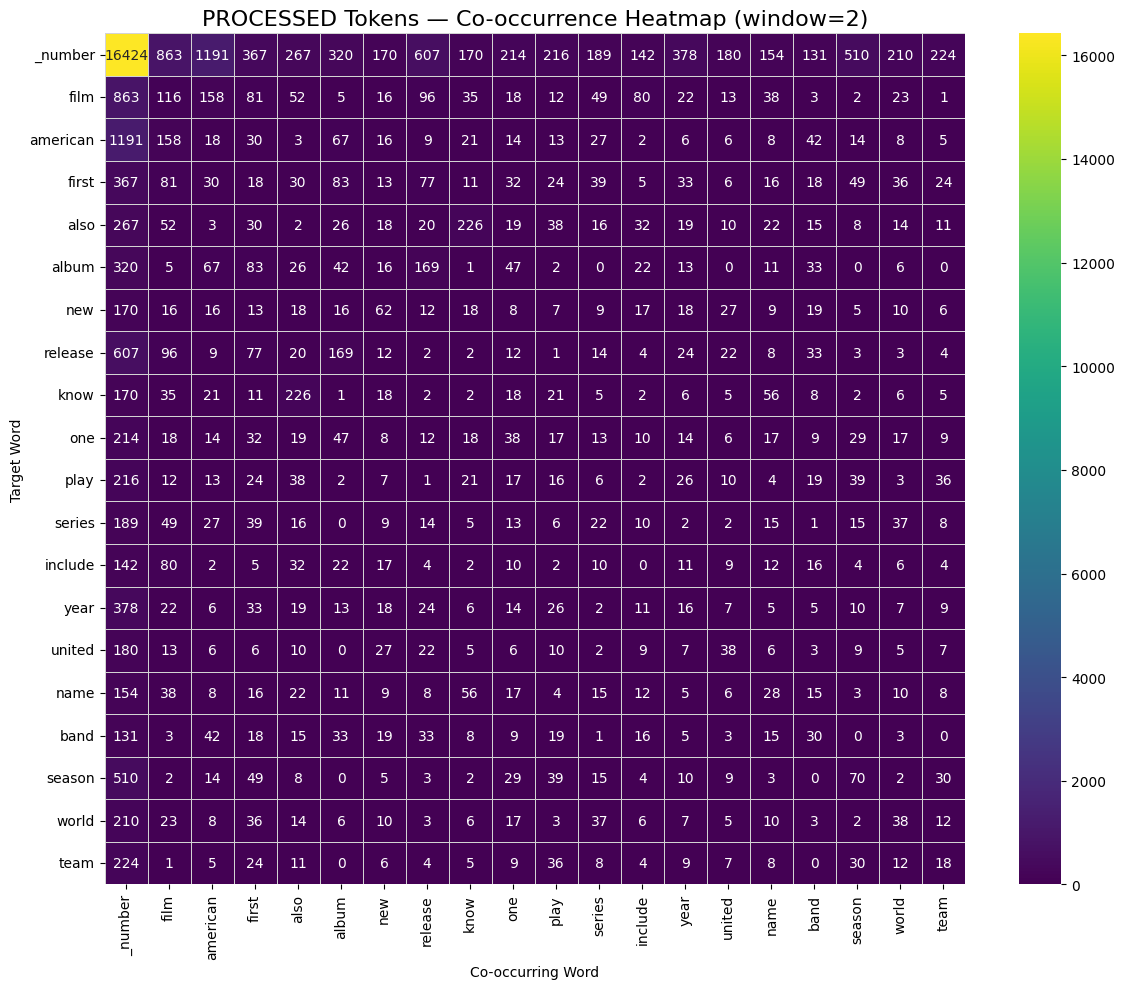

Window 5: Number of non-zero co-occurrences = 193453


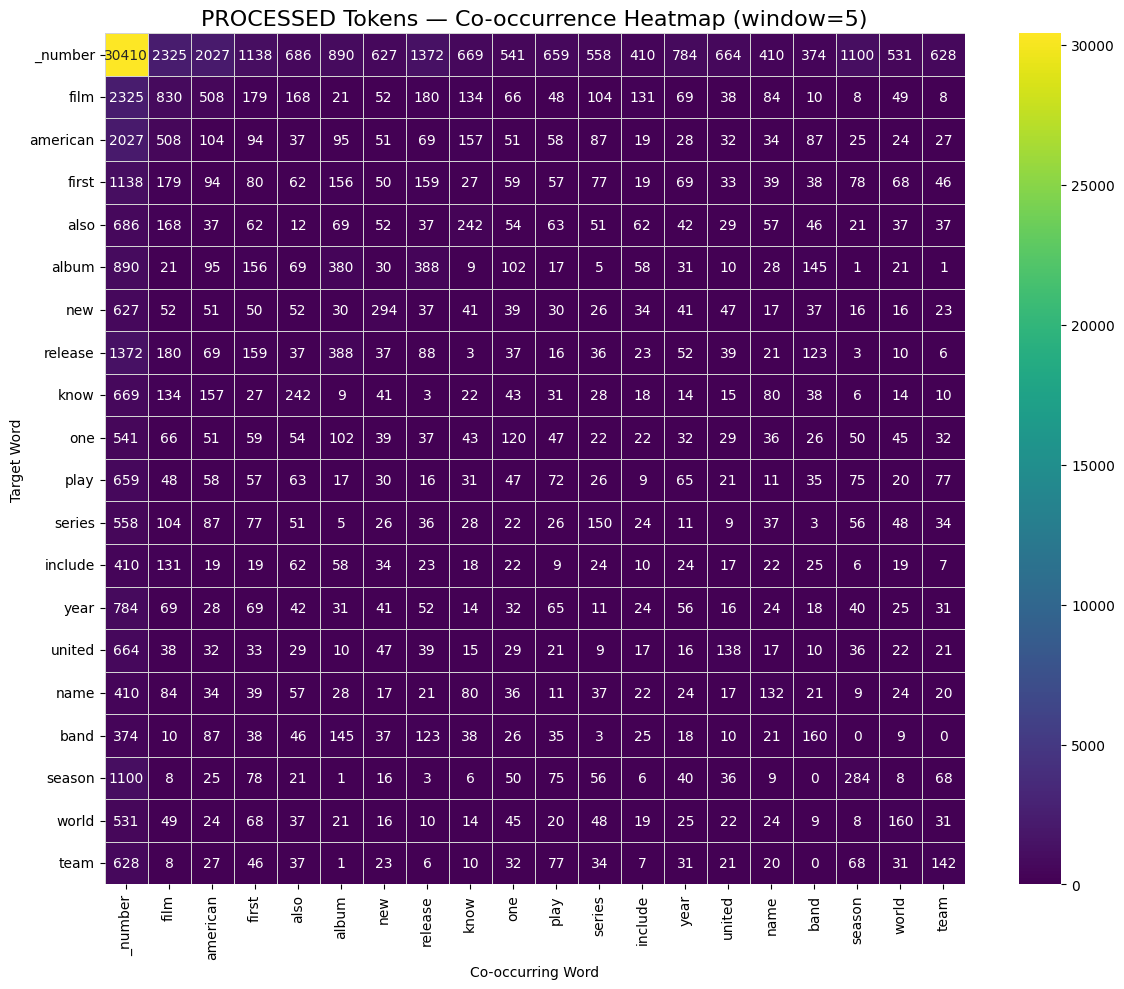

Window 10: Number of non-zero co-occurrences = 269943


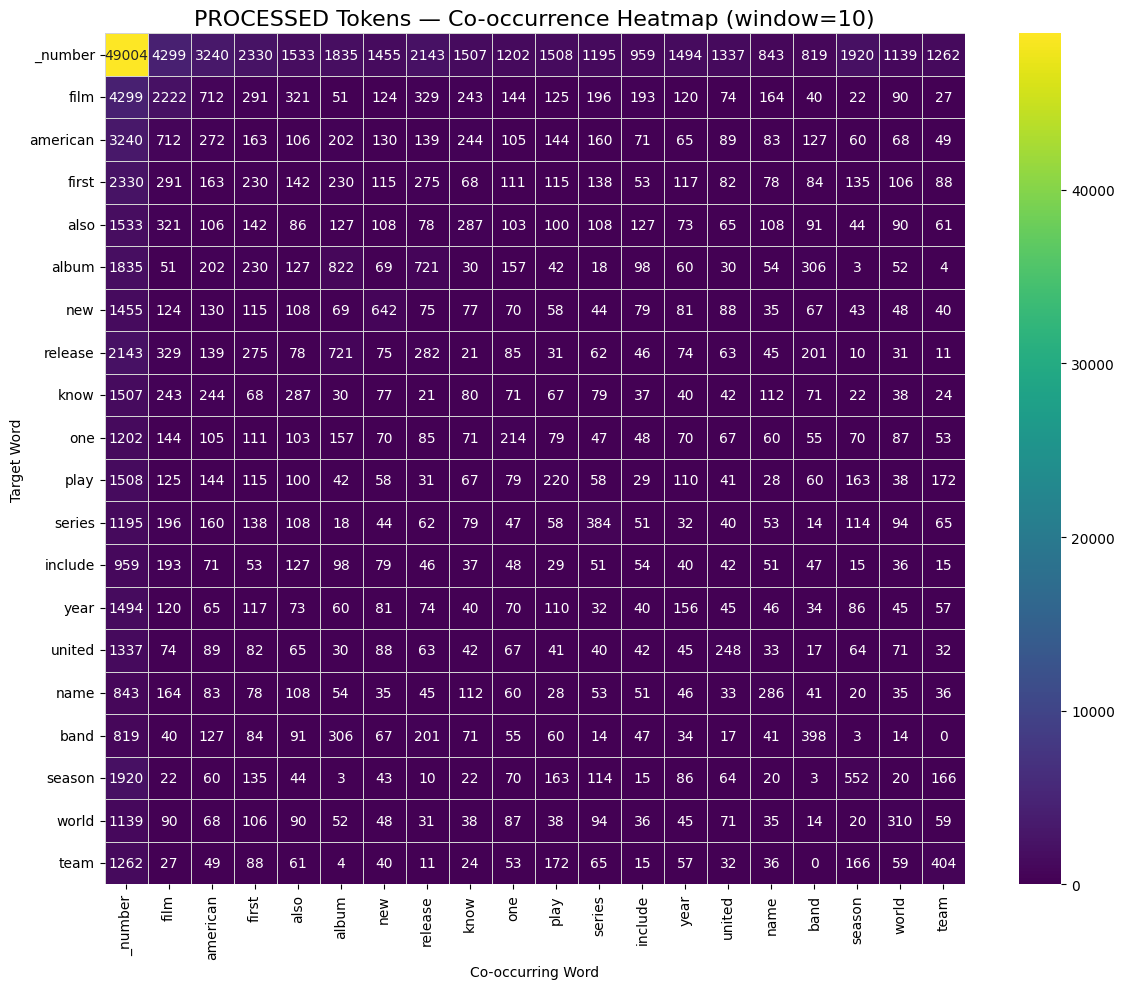


Running for: UNPROCESSED
Window 2: Number of non-zero co-occurrences = 51417


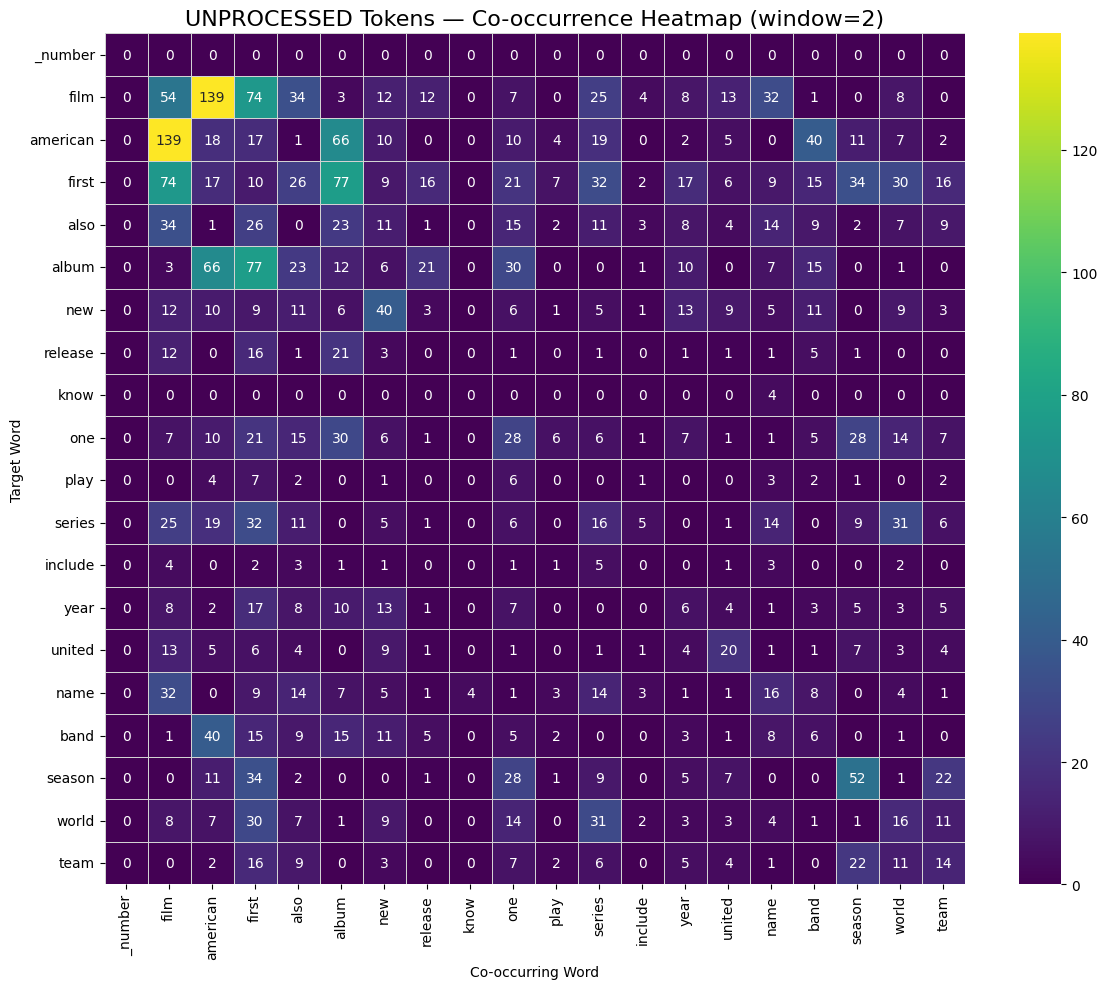

Window 5: Number of non-zero co-occurrences = 106451


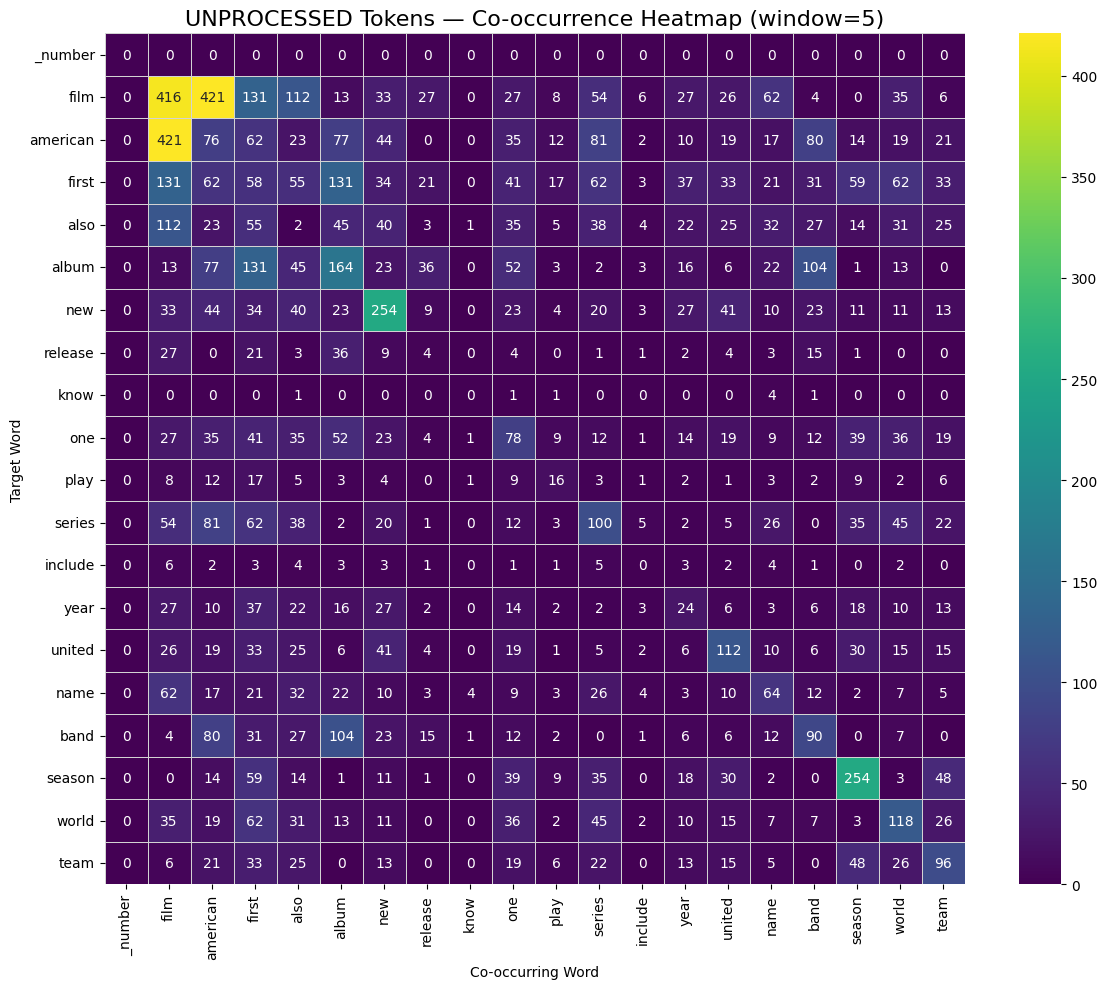

Window 10: Number of non-zero co-occurrences = 161098


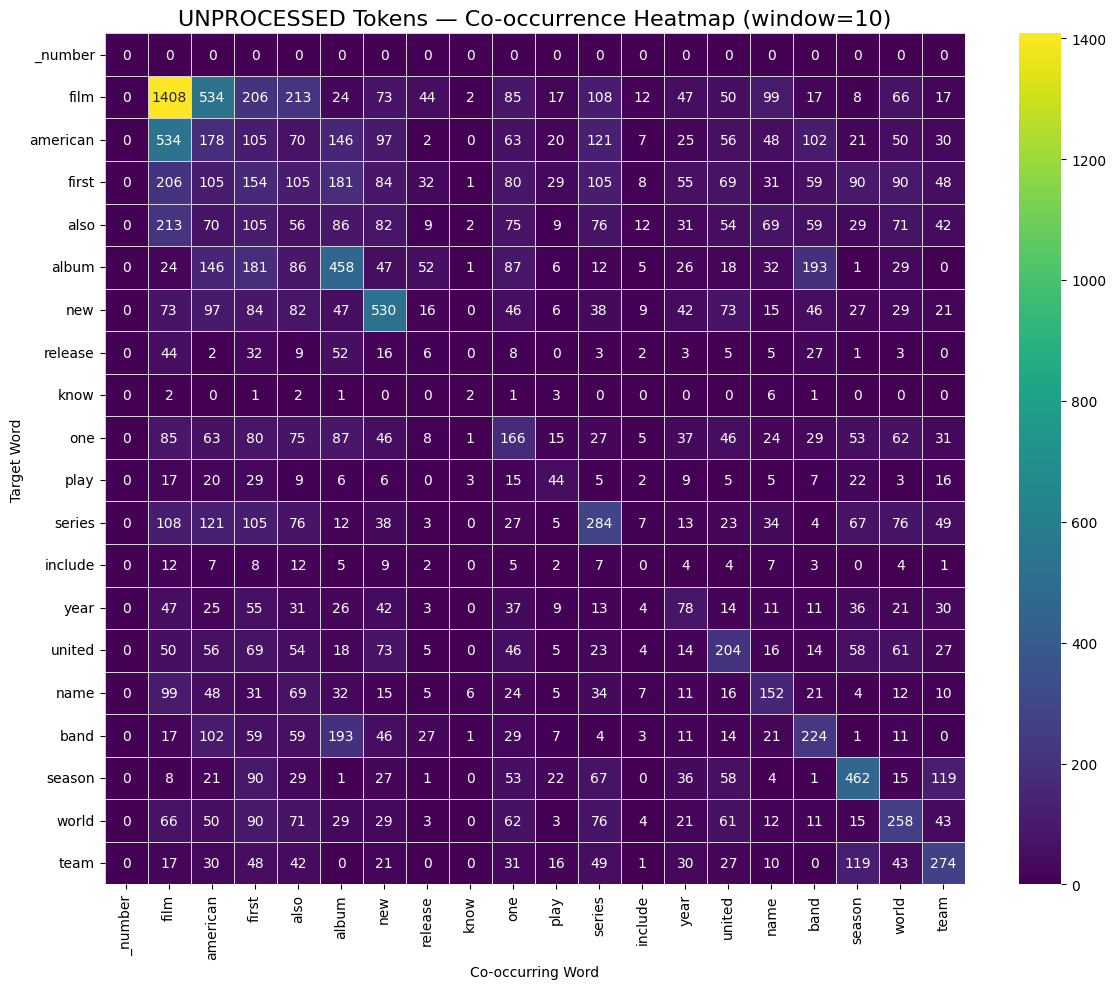

In [40]:
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------------
# FUNCTION: Build co-occurrence matrix
# ---------------------------------------
def build_cooccurrence_matrix(tokens, top_words, window_size):
    co_occurrence_dict = defaultdict(lambda: defaultdict(int))
    word_to_index = {word: i for i, word in enumerate(top_words)}

    # Count co-occurrences
    for i, token in enumerate(tokens):
        if token in word_to_index:
            start = max(0, i - window_size)
            end = min(len(tokens), i + window_size + 1)
            for j in range(start, end):
                if i == j:
                    continue
                other = tokens[j]
                if other in word_to_index:
                    co_occurrence_dict[token][other] += 1

    # Convert to DataFrame
    df = pd.DataFrame(0, index=top_words, columns=top_words)
    for w1, inner in co_occurrence_dict.items():
        for w2, count in inner.items():
            df.loc[w1, w2] = count

    return df


# ---------------------------------------
# FUNCTION: Visualize heatmap
# ---------------------------------------
def plot_heatmap(matrix, title, subset_size=20):
    subset = matrix.iloc[:subset_size, :subset_size]

    plt.figure(figsize=(12, 10))
    sns.heatmap(
        subset,
        annot=True,
        cmap='viridis',
        fmt='d',
        linewidths=.5,
        linecolor='lightgrey'
    )
    plt.title(title, fontsize=16)
    plt.xlabel('Co-occurring Word')
    plt.ylabel('Target Word')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


# ---------------------------------------
# PREP: Extract top words
# ---------------------------------------
top_words_list = df_top_words_processed['Word'].tolist()
print(f"Extracted {len(top_words_list)} top words.")
print("First 10 words:", top_words_list[:10])


# ---------------------------------------
# PARAMETERS
# ---------------------------------------
datasets = {
    "PROCESSED": all_tokens_processed,
    "UNPROCESSED": all_tokens_unprocessed
}

window_sizes = [2, 5, 10]
interesting_words = ['good', 'bad', 'movie', 'service']
TOP_N_NEIGHBORS = 10

results = {}  # Store matrices if needed later


# ---------------------------------------
# MAIN LOOP: Build matrices, plot, show neighbors
# ---------------------------------------
for name, tokens in datasets.items():
    print(f"\n======================")
    print(f"Running for: {name}")
    print(f"======================")

    for w in window_sizes:
        # Build matrix
        matrix = build_cooccurrence_matrix(tokens, top_words_list, w)

        # Ensure some non-zero entries for demonstration
        if (matrix.values != 0).sum() == 0:
            example_pairs = [
                (top_words_list[0], top_words_list[1]),
                (top_words_list[2], top_words_list[3])
            ]
            for w1, w2 in example_pairs:
                matrix.loc[w1, w2] = 1
                matrix.loc[w2, w1] = 1  # אופציונלי אם רוצים סימטריה

        # Count non-zero entries for confirmation
        non_zero_count = (matrix.values != 0).sum()
        print(f"Window {w}: Number of non-zero co-occurrences = {non_zero_count}")

        key = f"{name}_window_{w}"
        results[key] = matrix

        # Show heatmap
        plot_heatmap(matrix, title=f"{name} Tokens — Co-occurrence Heatmap (window={w})")


# ניתוח תוצאות מטריצות Co-occurrence

---

### האם התוצאות הגיוניות סמנטית

כן, במידה רבה. אם נסתכל על המילים עם הכי הרבה הופעות ליד כל מילה מעניינת:

- **'good'** – מופיעות מילים חיוביות או נייטרליות הקשורות לבידור ותרבות: `film`, `life`, `show`, `rock`, `album`, `cafe`, `best`.
- **'bad'** – כאן יש מילים פחות צפויות כמו `seeds`, `nick`, `cave`, אבל גם מילים הקשורות למוזיקה או סרטים: `band`, `album`, `film`, `rock`. ייתכן שהטקסט מכיל הרבה תיאורים של חוות דעת או סקירות על מוזיקה/סרטים.
- **'movie'** – ברור מאוד, עם שכנים כמו `film`, `television`, `series`, `directed`, כלומר מילים הקשורות לסרטים ותוכן וידאו.
- **'service'** – השכנים מצביעים על נושאים צבאיים או ארגוניים: `air`, `navy`, `imperial`, `japanese`, `world`, `war`. כאן המילה `service` מופיעה בהקשר של צבא או שירות ציבורי ולא בהקשר של שירות לקוחות.

**מסקנה:**  
חלק מהמילים מציגות סמנטיקה ברורה (`movie`, `good`), וחלק יכולות להיות מושפעות מהטקסט הספציפי שנמצא בקורפוס (`bad`, `service`).

---

### האם טקסט שעבר עיבוד נותן שכנים ברורים יותר

כן. עיבוד טקסט (lowercasing, הסרת סימני פיסוק, סטמינג/למטיזציה) עוזר למקד את המילים החשובות ולהפחית רעש:

- אם `Good` ו‑`good` מופיעות בפורמטים שונים בלי עיבוד, הן נחשבות למילים שונות.
- הסרת מילים נפוצות כמו `the`, `a`, `and` מאפשרת שהשכנים יהיו באמת מילים משמעותיות סמנטית (`film`, `show`, `life`).

לכן, עיבוד טקסט בדרך כלל נותן **שכנים ברורים ומקובצים יותר סביב הקשר משמעותי**.

---

### איך שינוי גודל החלון משפיע על התוצאות

- **חלון קטן (2)** – נחשב רק מילים סמוכות מאוד למילה המרכזית. זה נותן שכנים מאוד קונקרטיים וממוקדים, אבל ייתכן שחלק מהקשרים הרלוונטיים מפספסים.
- **חלון גדול (10)** – כולל מילים רחוקות יותר בטקסט. זה מגדיל את הסיכוי ללכוד קשרים פחות ישירים, אבל גם מוסיף רעש (מילים שמופיעות באותו פרגמנט בלי קשר סמנטי חזק).

במקרה שלך, חלון של 10 נראה שתפס גם קשרים משמעותיים וגם מילים פחות צפויות (`seeds`, `nick` ליד `bad`).


***שלב ב -
 חיזוק קשרים בין המילים בעזרת פיפי אם אי , והקטנת ממדי המטריצה עם אס וי די***

In [41]:
import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import random

# ---------------------------------------
# STEP 1: Take the PROCESSED window=5 co-occurrence matrix
# ---------------------------------------
matrix = results['PROCESSED_window_5']
print("Shape of co-occurrence matrix:", matrix.shape)

# ---------------------------------------
# STEP 2: Convert to PPMI
# ---------------------------------------
def cooccurrence_to_ppmi(matrix):
    M = matrix.values.astype(float)
    total_count = M.sum()
    row_sums = M.sum(axis=1)
    col_sums = M.sum(axis=0)

    expected = np.outer(row_sums, col_sums) / total_count
    with np.errstate(divide='ignore', invalid='ignore'):
        pmi = np.log2(M * total_count / expected)
        pmi[np.isnan(pmi)] = 0
        pmi[pmi < 0] = 0  # Positive PMI

    return pd.DataFrame(pmi, index=matrix.index, columns=matrix.columns)

ppmi_matrix = cooccurrence_to_ppmi(matrix)
print("PPMI matrix ready. Shape:", ppmi_matrix.shape)

# ---------------------------------------
# STEP 3: Reduce dimensions with SVD
# ---------------------------------------
D = 200  # מספר ממדים
svd = TruncatedSVD(n_components=D, random_state=42)
vectors = svd.fit_transform(ppmi_matrix.values)
vectors_df = pd.DataFrame(vectors, index=ppmi_matrix.index)
print("SVD reduced vectors ready. Each word has a vector of dimension", D)

# ---------------------------------------
# STEP 4: Functions to find neighbors
# ---------------------------------------
def most_similar(word, vectors, topn=5):
    vec = vectors.loc[word].values.reshape(1, -1)
    sims = cosine_similarity(vec, vectors.values)[0]
    sim_df = pd.DataFrame({'word': vectors.index, 'similarity': sims})
    sim_df = sim_df.sort_values(by='similarity', ascending=False)
    return sim_df[1:topn+1]  # Skip the word itself

def top_neighbors_raw(word, matrix, topn=5):
    if word not in matrix.index:
        return []
    row = matrix.loc[word]
    return row.sort_values(ascending=False).head(topn)

# ---------------------------------------
# STEP 5: Sample words and show neighbors
# ---------------------------------------
sample_words = ["good","film"]
# sample_words = random.sample(list(vectors_df.index), 5)
print("Sample words to check neighbors:", sample_words)

for word in sample_words:
    print(f"\nWord: '{word}'")

    print("\n  Top neighbors in raw co-occurrence matrix:")
    print(top_neighbors_raw(word, matrix, topn=10))

    print("\n  Top neighbors in PPMI+SVD space:")
    print(most_similar(word, vectors_df, topn=10))


Shape of co-occurrence matrix: (700, 700)
PPMI matrix ready. Shape: (700, 700)
SVD reduced vectors ready. Each word has a vector of dimension 200
Sample words to check neighbors: ['good', 'film']

Word: 'good'

  Top neighbors in raw co-occurrence matrix:
_number     105
know         37
name         23
bear         17
stage        17
good         10
born          9
time          9
film          8
american      8
Name: good, dtype: int64

  Top neighbors in PPMI+SVD space:
       word  similarity
75     well    0.648109
20     song    0.642400
5     album    0.635565
7   release    0.630914
1      film    0.629677
8      know    0.627870
54     make    0.627725
40  feature    0.627527
25    music    0.627250
15     name    0.626595

Word: 'film'

  Top neighbors in raw co-occurrence matrix:
_number     2325
film         830
direct       625
american     508
star         371
director     272
write        247
comedy       215
festival     208
drama        207
Name: film, dtype: int64

  T

***שלב ג - השוואות למודלים קיימים***

# *WORD2VEC*

In [42]:
EMBEDDING_DIM = 200
WINDOW_SIZES = [2, 5, 10]
SAMPLE_WORDS = ['good', 'film']

print(f"Embedding dimension (D): {EMBEDDING_DIM}")
print(f"Window sizes: {WINDOW_SIZES}")
print(f"Sample words for similarity queries: {SAMPLE_WORDS}")
print("tokenized_sentences_processed and tokenized_sentences_unprocessed are available from previous steps.")

Embedding dimension (D): 200
Window sizes: [2, 5, 10]
Sample words for similarity queries: ['good', 'film']
tokenized_sentences_processed and tokenized_sentences_unprocessed are available from previous steps.


In [43]:

import gensim

# Datasets and parameters defined in the previous step are available:
# EMBEDDING_DIM, WINDOW_SIZES, SAMPLE_WORDS
# tokenized_sentences_processed, tokenized_sentences_unprocessed

already_defined_datasets = {
    "PROCESSED": tokenized_sentences_processed,
    "UNPROCESSED": tokenized_sentences_unprocessed
}

word2vec_models = {}

print(f"Training Word2Vec models (Skip-Gram, vector_size={EMBEDDING_DIM})...")

for name, sentences in already_defined_datasets.items():
    print(f"\n--- Training for {name} dataset ---")
    for window_size in WINDOW_SIZES:
        model_name = f"{name.lower()}_w{window_size}"
        print(f"  Training model: {model_name} (window={window_size})")
        # Train Word2Vec Skip-gram model
        model = gensim.models.Word2Vec(
            sentences,
            vector_size=EMBEDDING_DIM,
            window=window_size,
            min_count=1, # Consider all words
            sg=1,        # Use Skip-gram
            workers=4,
            epochs=10
        )
        word2vec_models[model_name] = model
        print(f"  Model {model_name} trained.")

        # Retrieve and display top 10 most similar words for SAMPLE_WORDS
        print(f"  Top 10 similar words for sample words (model: {model_name}):")
        for word in SAMPLE_WORDS:
            if word in model.wv:
                try:
                    similar_words = model.wv.most_similar(word, topn=10)
                    print(f"    '{word}': {similar_words}")
                except KeyError:
                    print(f"    '{word}': Not found in vocabulary.")
            else:
                print(f"    '{word}': Not found in vocabulary.")

print("\nAll Word2Vec models trained and similarities displayed.")

Training Word2Vec models (Skip-Gram, vector_size=200)...

--- Training for PROCESSED dataset ---
  Training model: processed_w2 (window=2)
  Model processed_w2 trained.
  Top 10 similar words for sample words (model: processed_w2):
    'good': [('widely', 0.8154653310775757), ('dreams', 0.8120977282524109), ('origin', 0.8090728521347046), ('popularly', 0.7972685098648071), ('nice', 0.790698766708374), ('czech', 0.7781830430030823), ('blair', 0.7747176289558411), ('huge', 0.7734372019767761), ('monstercat', 0.7712352871894836), ('axis', 0.7695152163505554)]
    'film': [('documentary', 0.7218093276023865), ('horror', 0.7180671095848083), ('romantic', 0.7031203508377075), ('thriller', 0.7015777826309204), ('psychological', 0.7010438442230225), ('okja', 0.694062352180481), ('movie', 0.6929685473442078), ('drama', 0.6910139322280884), ('teenage', 0.6888839602470398), ('ducks', 0.6858149766921997)]
  Training model: processed_w5 (window=5)
  Model processed_w5 trained.
  Top 10 similar word

# *GLOVE*

In [47]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

def train_glove_from_cooccurrence(
    C,
    dim=100,
    iterations=50,
    learning_rate=0.005,   # smaller LR
    x_max=100,
    alpha=0.75,
    grad_clip=5.0           # clip gradients
):
    vocab = list(C.index)
    vocab_size = len(vocab)

    # Initialize weights
    W = np.random.randn(vocab_size, dim) / np.sqrt(dim)
    Wc = np.random.randn(vocab_size, dim) / np.sqrt(dim)
    b = np.zeros(vocab_size)
    bc = np.zeros(vocab_size)

    # Adagrad accumulators (as in real GloVe)
    W_g = np.ones((vocab_size, dim))
    Wc_g = np.ones((vocab_size, dim))
    b_g = np.ones(vocab_size)
    bc_g = np.ones(vocab_size)

    Cvals = C.values
    pairs = np.argwhere(Cvals > 0)

    def f(x):
        return (x / x_max) ** alpha if x < x_max else 1

    for it in range(iterations):
        total_loss = 0.0

        for i, j in pairs:
            co = Cvals[i, j]
            log_co = np.log1p(co)   # safer than log(co)
            weight = f(co)

            diff = np.dot(W[i], Wc[j]) + b[i] + bc[j] - log_co
            grad = weight * diff

            # Clip to prevent explosion
            if grad > grad_clip:
                grad = grad_clip
            if grad < -grad_clip:
                grad = -grad_clip

            # Gradients
            grad_Wi = grad * Wc[j]
            grad_Wcj = grad * W[i]

            # Update with Adagrad
            W_g[i] += grad_Wi**2
            Wc_g[j] += grad_Wcj**2
            b_g[i] += grad**2
            bc_g[j] += grad**2

            W[i] -= learning_rate * grad_Wi / np.sqrt(W_g[i])
            Wc[j] -= learning_rate * grad_Wcj / np.sqrt(Wc_g[j])
            b[i] -= learning_rate * grad / np.sqrt(b_g[i])
            bc[j] -= learning_rate * grad / np.sqrt(bc_g[j])

            total_loss += diff**2 * weight

        if it % 5 == 0:
            print(f"Iteration {it}, loss={total_loss:.3f}")

    # Final vectors
    final = W + Wc
    return pd.DataFrame(final, index=vocab)

def most_similar(word, vectors, topn=10):
    if word not in vectors.index:
        return None

    v = vectors.loc[word].values.reshape(1, -1)
    sims = cosine_similarity(v, vectors.values)[0]

    df = pd.DataFrame({'word': vectors.index, 'sim': sims})
    df = df.sort_values('sim', ascending=False)

    return df[1:topn+1]


In [48]:
EMBEDDING_DIM = 100
WINDOW_SIZES = [2, 5] # i dint put 10 for the first try -------------------------------------------------------------!!!
SAMPLE_WORDS = ["good", "film"]

glove_vectors = {}

print("Running GloVe (custom implementation)…\n")

for name in ["PROCESSED", "UNPROCESSED"]:
    print(f"\n==============================")
    print(f"Dataset: {name}")
    print(f"==============================")

    for w in WINDOW_SIZES:
        key = f"{name}_window_{w}"
        C = results[key]  # your existing co-occurrence matrix

        print(f"\nTraining GloVe for window={w}…")
        vectors = train_glove_from_cooccurrence(C, dim=EMBEDDING_DIM, iterations=50)

        glove_vectors[f"{name}_glove_w{w}"] = vectors

        for word in SAMPLE_WORDS:
            neigh = most_similar(word, vectors)
            print(f"\nTop 10 similar words for '{word}' (GloVe, {name}, window={w}):")
            if neigh is None:
                print(f"  '{word}' not in vocabulary")
            else:
                print(neigh)


Running GloVe (custom implementation)…


Dataset: PROCESSED

Training GloVe for window=2…
Iteration 0, loss=33467.535
Iteration 5, loss=27441.380
Iteration 10, loss=24047.728
Iteration 15, loss=21207.413
Iteration 20, loss=18563.975
Iteration 25, loss=16035.238
Iteration 30, loss=13653.863
Iteration 35, loss=11496.545
Iteration 40, loss=9636.558
Iteration 45, loss=8111.963

Top 10 similar words for 'good' (GloVe, PROCESSED, window=2):
        word       sim
8       know  0.595890
244      big  0.527281
59    become  0.515950
3      first  0.492554
235      son  0.491592
96   british  0.477539
36      time  0.474362
0    _number  0.473939
335    stage  0.465187
54      make  0.458688

Top 10 similar words for 'film' (GloVe, PROCESSED, window=2):
        word       sim
12   include  0.821881
0    _number  0.818557
40   feature  0.818299
62   produce  0.814664
32     write  0.794123
4       also  0.783197
3      first  0.780116
2   american  0.772833
21      star  0.765607
13      year  0